In [1]:
import json
import os
import multiprocessing as mp
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from itertools import combinations
from scipy.optimize import minimize
from pathlib import Path
from tqdm import tqdm

from qiskit import QuantumCircuit
from qiskit.primitives import (
    BackendSampler,
    BackendSamplerV2,
    BackendEstimator,
    BackendEstimatorV2,
    StatevectorEstimator,
    Estimator,
)
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import EfficientSU2, TwoLocal
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.algorithms import MinimumEigenOptimizer, GurobiOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_algorithms import NumPyMinimumEigensolver, VQE
from qiskit_algorithms.optimizers import NELDER_MEAD, COBYLA, L_BFGS_B
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import (
    Sampler as AerSampler,
    SamplerV2 as AerSamplerV2,
    Estimator as AerEstimator,
    EstimatorV2 as AerEstimatorV2,
)

from lcc import LCCVQE, FullVQE
from lcc.knapsack import Knapsack
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit.circuit.library import QAOAAnsatz

# VQE ansatz

In [11]:
%%time

def generate_graph(n):
    G = nx.random_regular_graph(3, n, seed=0)
    max_cut = Maxcut(G)
    qp = max_cut.to_quadratic_program()
    conv = QuadraticProgramToQubo()
    qubo = conv.convert(qp)
    hamiltonian, offset = qubo.to_ising()
    return qp, hamiltonian

def compute_gradient(sample_idx, r, estimator, optimizer, grad, qp, hamiltonian):
    np.random.seed(os.getpid())  
    solver = FullVQE(
        qp,
        estimator=estimator,
        optimizer=optimizer,
        reps=r
    )
    
    initial_params = solver.generate_random_params()
    qc = solver.full_ansatz
    result = grad.run(qc, hamiltonian, [initial_params]).result().gradients
    
    return result

if __name__ == '__main__':
    n_values = [6, 8, 10, 12]
    # n_values = [6]
    # reps = [1, 5, 10, 20, 50, 100, 150, 200, 250, 300]
    reps = [1, 5, 10]
    samples = 100
    num_procs = mp.cpu_count() - 1
    batch_size = 12

    estimator = Estimator()
    optimizer = COBYLA()
    grad = ParamShiftEstimatorGradient(estimator)

    all_gradients_q_d = {}

    for n in n_values:
        qp, hamiltonian = generate_graph(n)
        gradients_q_d = []

        for r in reps:
            gradients_d_all = []

            for batch_start in range(0, samples, batch_size):
                batch_end = min(batch_start + batch_size, samples)

                processes = []
                manager = mp.Manager()
                results = manager.list()

                for sample_idx in range(batch_start, batch_end):
                    p = mp.Process(
                        target=lambda idx, res: res.append(
                            compute_gradient(idx, r, estimator, optimizer, grad, qp, hamiltonian)
                        ),
                        args=(sample_idx, results)
                    )
                    p.start()
                    processes.append(p)

                for p in processes:
                    p.join()

                valid_results = [g for g in results if g is not np.nan and not np.isnan(g).any()]
                gradients_d_all.extend(valid_results)

            if len(gradients_d_all) > 1:  
                gradients_d_var = np.var(gradients_d_all, ddof=1)
            else:
                gradients_d_var = np.nan  

            gradients_q_d.append(gradients_d_var)

        print(f'For n = {n}, Gradient Variances: {gradients_q_d}')

        all_gradients_q_d[n] = gradients_q_d

<timed exec>:34: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.


For n = 6, Gradient Variances: [0.12254602786983229, 0.06537128793954945, 0.05084034333843176]
For n = 8, Gradient Variances: [0.11763126026946252, 0.053329435119988174, 0.03549671709456366]
For n = 10, Gradient Variances: [0.09483568697911969, 0.033485116520319894, 0.02055477063340869]
For n = 12, Gradient Variances: [0.09881573454557856, 0.028062078978939652, 0.014018807055712713]
CPU times: user 715 ms, sys: 3.88 s, total: 4.59 s
Wall time: 1min 41s


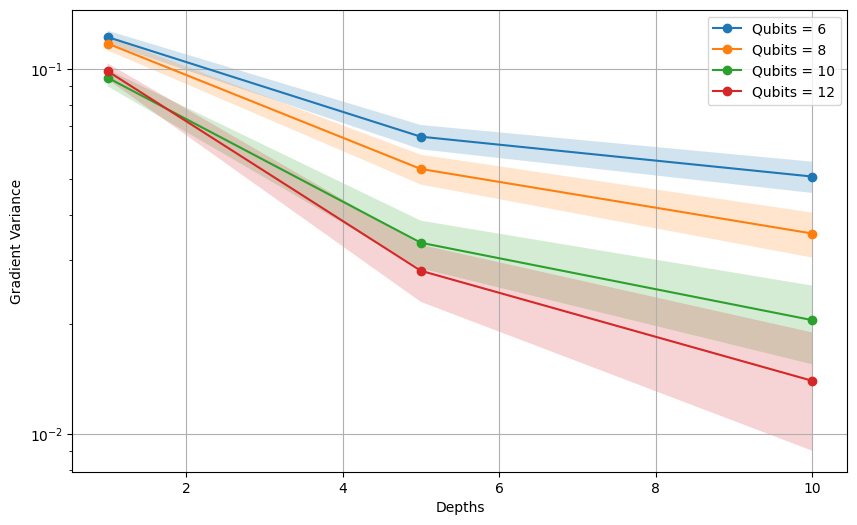

In [12]:
plt.figure(figsize=(10, 6))
for n, gradients in all_gradients_q_d.items():
    plt.plot(reps, gradients, marker='o', linestyle='-', label=f'Qubits = {n}')
    plt.fill_between(reps, 
                 [x - 0.005 for x in gradients], 
                 [x + 0.005 for x in gradients], 
                 alpha=0.2)

plt.yscale('log')
plt.xlabel('Depths')
plt.ylabel('Gradient Variance')
plt.legend()
plt.grid(True)
# plt.savefig('/home/yanxinjian/qiskit_gardient/6-12qubit.png',bbox_inches='tight')
plt.show()

# QAOA ansatz

In [18]:
%%time

def generate_graph(n):
    G = nx.random_regular_graph(3, n, seed=0)
    max_cut = Maxcut(G)
    qp = max_cut.to_quadratic_program()
    conv = QuadraticProgramToQubo()
    qubo = conv.convert(qp)
    hamiltonian, offset = qubo.to_ising()
    return qp, hamiltonian

def compute_gradient(sample_idx, r, estimator, optimizer, grad, qp, hamiltonian):
    np.random.seed(os.getpid()) 
    
    gamma = np.random.uniform(0, 2*np.pi)
    beta = np.random.uniform(0, np.pi)
    initial_params = [gamma, beta] * r
    
    qc = QAOAAnsatz(cost_operator=hamiltonian, reps=r)

    result = grad.run(qc, hamiltonian, [initial_params]).result().gradients

    # print(result)
    
    return result

if __name__ == '__main__':
    n_values = [6, 8, 10, 12]
    # n_values = [6]
    # reps = [1, 5, 10, 20, 50, 100, 150, 200, 250, 300]
    reps = [1, 5]
    samples = 10
    num_procs = mp.cpu_count() - 1
    batch_size = 12

    estimator = Estimator()
    optimizer = COBYLA()
    grad = ParamShiftEstimatorGradient(estimator)

    all_gradients_q_d = {}

    for n in n_values:
        qp, hamiltonian = generate_graph(n)
        gradients_q_d = []

        for r in reps:
            gradients_d_all = []

            for batch_start in range(0, samples, batch_size):
                batch_end = min(batch_start + batch_size, samples)

                processes = []
                manager = mp.Manager()
                results = manager.list()

                for sample_idx in range(batch_start, batch_end):
                    p = mp.Process(
                        target=lambda idx, res: res.append(
                            compute_gradient(idx, r, estimator, optimizer, grad, qp, hamiltonian)
                        ),
                        args=(sample_idx, results)
                    )
                    p.start()
                    processes.append(p)

                for p in processes:
                    p.join()

                valid_results = [g for g in results if g is not np.nan and not np.isnan(g).any()]
                gradients_d_all.extend(valid_results)

            if len(gradients_d_all) > 1:  
                gradients_d_var = np.var(gradients_d_all, ddof=1)
            else:
                gradients_d_var = np.nan  

            gradients_q_d.append(gradients_d_var)

        print(f'For n = {n}, Gradient Variances: {gradients_q_d}')

        all_gradients_q_d[n] = gradients_q_d

<timed exec>:34: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.


For n = 6, Gradient Variances: [6.321395432950424, 6.064865504779654]
For n = 8, Gradient Variances: [11.779581481967194, 5.911096349115411]
For n = 10, Gradient Variances: [26.721404511139976, 13.039470076786523]
For n = 12, Gradient Variances: [31.401944204067856, 14.114979517278135]
CPU times: user 72.2 ms, sys: 286 ms, total: 358 ms
Wall time: 6.11 s
Parser   : 113 ms


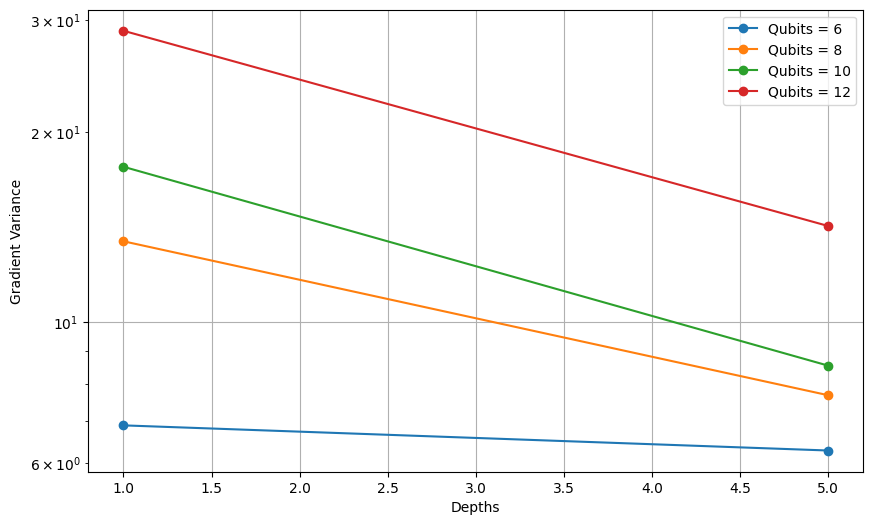

In [14]:
plt.figure(figsize=(10, 6))
for n, gradients in all_gradients_q_d.items():
    plt.plot(reps, gradients, marker='o', linestyle='-', label=f'Qubits = {n}')
    plt.fill_between(reps, 
                 [x - 0.005 for x in gradients], 
                 [x + 0.005 for x in gradients], 
                 alpha=0.2)

plt.yscale('log')
plt.xlabel('Depths')
plt.ylabel('Gradient Variance')
plt.legend()
plt.grid(True)
# plt.savefig('/home/yanxinjian/qiskit_gardient/6-12qubit.png',bbox_inches='tight')
plt.show()